For when you want to do something quick and dont want 
to make the whole project tree you can just write a small script to do the job, that means ork in a single .py file

In [3]:
# quotes.py

from scrapy import Spider 
from scrapy.http import FormRequest 

class QuotesSpider(scrapy.Spider):
    name = 'quotes_'
    start_urls = ('http://quotes.toscrape.com/login')
    
    def parse(self, response):
        token = response.xpath('//*[@name="csrf_token"]/@value').extract_first()
        return FormRequest.from_response(response,
                                         formdata = {'csrf_token': token,
                                                     'username': 'Blah' ,
                                                     'password': 'Blah'},
                                        callback = self.scrape_home_page)
        
    
    def scrape_home_page(self, response):
        h1_tag = response.xpath('//h1/a/text()').extract_first()
        tags_var = response.xpath('//*[@class="tag-item"]/a/text()').extract()
        
        print(h1_tag)
        print(tags_var)
        

In [ ]:
$ scrapy runspider quotes.py

###  Web Crawler
scrapy startproject books_crawler  
cd books_crawler  
scrapy genspider books_ books.toscrape.com

To Run:  
scrapy crawl books_

In [ ]:
# books_.py
# For crawler change scrapy.Spider to CrawlSpider as inherited class
# Change Settings.py ROBOTS_TXT = False

from scrapy.spiders import CrawlSpider, rule
from scrapy.linkextractors import LinkExtractor

class BooksSpider(CrawlSpider):
    name = 'books_'
    allowed_domains = ['books.toscrape.com']
    start_urls = ['http://books.toscrape.com/']

    rules = (Rule(LinkExtractor(), callback='parse_page', follow=True))
    # LinkExtractor(deny_domains=('google.com')) # Should do for all social media as well
    # LinkExtractor(allow=('music')) # All those url with music in them
    # If follow = False then wont go to the next page

    def parse_page(self, response):
        yield {'URL': response.url}


### Scrapy With Selenium
https://selenium-python.readthedocs.io/


In [4]:
# import sys
# !{sys.executable} -m pip install selenium

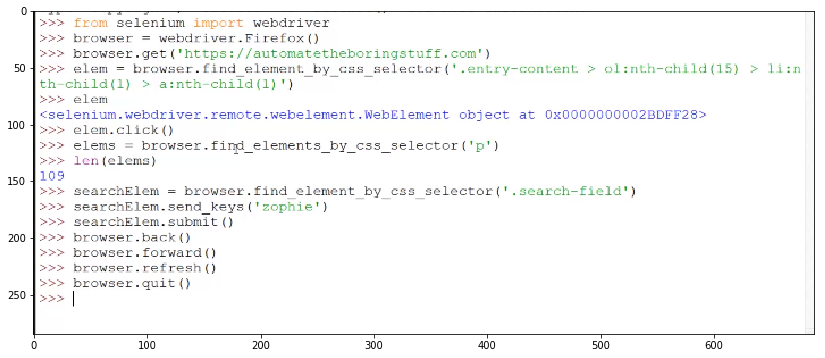

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def showImage(x):    
    plt.figure(figsize=(14,12))
    img = mpimg.imread('Selenium.PNG')
    plt.imshow(img)
showImage(1)

In [ ]:
from selenium import webdriver
driver = webdriver.Chrome('../../chromedriver.exe')
driver.get('http://google.com')

In [ ]:
# books_.py
from time import sleep

from scrapy import Spider
from selenium import webdriver
from scrapy.selector import Selector
from scrapy.http import Request
from selenium.common.exceptions import NoSuchElementException


class BooksSpider(Spider):
    name = 'books_'
    allowed_domains = ['books.toscrape.com']

    def start_requests(self):
        self.driver = webdriver.Chrome('C:/Users/Acer/Desktop/Codes/chromedriver.exe')
        self.driver.get('http://books.toscrape.com')

        sel = Selector(text=self.driver.page_source)
        books = sel.xpath('//h3/a/@href').extract()
        for book in books:
            url = 'http://books.toscrape.com/' + book
            yield Request(url, callback=self.parse_book)

        while True:
            try:
                next_page = self.driver.find_element_by_xpath('//a[text()="next"]')
                sleep(3)
                self.logger.info('Sleeping for 3 seconds.')
                next_page.click()

                sel = Selector(text=self.driver.page_source)
                books = sel.xpath('//h3/a/@href').extract()
                for book in books:
                    url = 'http://books.toscrape.com/catalogue/' + book
                    yield Request(url, callback=self.parse_book)

            except NoSuchElementException:
                self.logger.info('No more pages to load.')
                self.driver.quit()
                break

    def parse_book(self, response):
        pass

### Web Scraper BooksToScrape.com
This is a complete webscraper using scrapy which extracts data 
as well as goes through all URLs to fetch it.

In [ ]:
# -*- coding: utf-8 -*-
from scrapy import Spider
from scrapy.http import Request


def product_info(response, value):
    return response.xpath('//th[text()="' + value + '"]/following-sibling::td/text()').extract_first()


class BooksSpider(Spider):
    name = 'books'
    allowed_domains = ['books.toscrape.com']
    start_urls = ['http://books.toscrape.com']

    # Grabbing URLs
    def parse(self, response):
    	# On each item we callback parse_book
        books = response.xpath('//h3/a/@href').extract()
        for book in books:
            absolute_url = response.urljoin(book)
            yield Request(absolute_url, callback=self.parse_book)

        # process next page
        # There are 50 pages so this code is to traverse all those pages
        next_page_url = response.xpath('//a[text()="next"]/@href').extract_first()
        absolute_next_page_url = response.urljoin(next_page_url)
        yield Request(absolute_next_page_url)

    # Data Extraction
    def parse_book(self, response):
    	# title = response.xpath('//h1/text()').extract_first()
        title = response.css('h1::text').extract_first()
        price = response.xpath('//*[@class="price_color"]/text()').extract_first()

        image_url = response.xpath('//img/@src').extract_first()
        image_url = image_url.replace('../..', 'http://books.toscrape.com/')

        # Not using [@class="star-rating"] because it is "star-rating three" so we use contain
        rating = response.xpath('//*[contains(@class, "star-rating")]/@class').extract_first()
        rating = rating.replace('star-rating ', '')

        # Following sibling means
        # <div id ="product_description">
        # 	<h2> ... </h2> 
        # </div>
        # <p> </p>
        description = response.xpath(
            '//*[@id="product_description"]/following-sibling::p/text()').extract_first()

        # product information data points
        upc = product_info(response, 'UPC')
        product_type =  product_info(response, 'Product Type')
        price_without_tax = product_info(response, 'Price (excl. tax)')
        price_with_tax = product_info(response, 'Price (incl. tax)')
        tax = product_info(response, 'Tax')
        availability = product_info(response, 'Availability')
        number_of_reviews = product_info(response, 'Number of reviews')

        yield {
            'title': title,
            'price': price,
            'image_url': image_url,
            'rating': rating,
            'description': description,
            'upc': upc,
            'product_type': product_type,
            'price_without_tax': price_without_tax,
            'price_with_tax': price_with_tax,
            'tax': tax,
            'availability': availability,
            'number_of_reviews': number_of_reviews
        }

#### Continue from 'More about scrapy'